# Identifying neighbor-dependent genes from seqFISH data in a mouse embryo

## Import packages

In [1]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import os

In [2]:
import CellNeighborEX

print('Version:', CellNeighborEX.__version__)

Version: 0.0.5


## Download data
From spatial transcriptomics data with various formats including h5ad, we can obtain data regarding gene expression, cell type annotation (via additional analysis), and spatial coordinates. CellNeighborEX takes the data transformed to Pandas Dataframes as input. In this tutorial, we use the mouse embryo seqFISH data pre-processed by Squidpy (https://squidpy.readthedocs.io/en/stable/api/squidpy.datasets.seqfish.html).

In [3]:
adata = sq.datasets.seqfish()  # 19416 cells x 351 genes

## Find nearest neighbors for cell contact

In [4]:
# Create a dataframe from the provided AnnData object.
# coord_key (str): Key to access the spatial coordinates in `adata.obsm`.
# celltype_key (str): Key to access the cell type information in `adata.obs`.
df =  CellNeighborEX.neighbors.create_dataframe(adata, coord_key='spatial', celltype_key='celltype_mapped_refined')

Calculating closest distances: 100%|██████████| 19416/19416 [05:33<00:00, 58.16it/s]


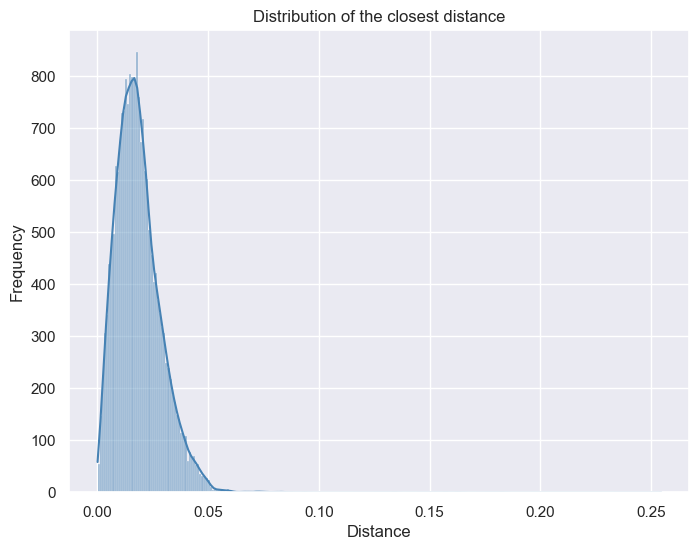

In [5]:
# (Optional) Calculate the closest distance between cells.
# If save=True, the result (closest_distance_distribution.pdf) is saved in the "neighbor_info" folder in the root directory.
closest_distances = CellNeighborEX.neighbors.calculate_closest_distance(df, save=True)

In [6]:
# Check the path of your root directory.
os.getcwd()

'/Users/kimh15/Downloads'

In [7]:
# Find immediate neighbors using Delaunay triangulation and retrieve the spatial connectivity matrix.
matrix = CellNeighborEX.neighbors.detect_neighbors(adata, coord_key='spatial', type='generic', knn=None, radius_value=None, delaunay=True)

# Calculate the number of neighbors for each cell.
neiNum = CellNeighborEX.neighbors.get_neighbors(matrix)

In [ ]:
# Processes the dataframe by adding additional columns based on the neighbor matrix and neighbor counts.
# If save=True, the result (df_processed.csv) is saved in the "neighbor_info" folder in the root directory.
df_processed = CellNeighborEX.neighbors.process_dataframe(df, matrix, neiNum, save=True) 

In [9]:
df_processed.head(5) # celltype1 is the cell type of a centered cell, and celltype2 is its neighboring cell type. first_type and second_type are numbers correspond to the cell types.

barcode  first_type  second_type               celltype1  \
0   embryo1_Pos0_cell10_z5          12           11  Lateral-plate-mesoderm   
1  embryo1_Pos0_cell100_z2           7           13               Erythroid   
2  embryo1_Pos0_cell102_z2           9            9                Gut-tube   
3  embryo1_Pos0_cell102_z5           6            9             Endothelium   
4  embryo1_Pos0_cell103_z5          12            0  Lateral-plate-mesoderm   

               celltype2         x         y  prop1  prop2  
0  Intermediate-mesoderm  0.708437 -2.707126    1.0    0.0  
1            Low-quality  0.961726 -2.943951    1.0    0.0  
2               Gut-tube  0.983054 -3.284372    1.0    0.0  
3               Gut-tube  0.993388 -3.200491    1.0    0.0  
4              Allantois  0.983855 -2.634190    1.0    0.0

## Categorize cells into heterotypic neighbors and homotypic neighbors for each cell type
To run CellNeighborEX, information on cell type annotation, spatial location, and expression values is required. Specifically, we need two types of input: (i) data files categorized per cell type, and (ii) log-normalized expression data.

### Generate data files categorized per cell type

In [ ]:
# All categorzied files (index_, matchComb_, neiCombUnique_, prop_ .csv) are saved in the "categorized_data folder" in the root directory.
CellNeighborEX.categorization.generate_input_files(data_type = "Image", df = df_processed, sample_size=30, min_sample_size=1)

In [11]:
# Set the path of the directory where all the categorized data files are saved.
path_categorization = '/Users/kimh15/Downloads/categorized_data/'  

# (Optional) Remove categorized data files with a specific keyword: this function can be used to exclude unwanted cell types.
specific_keyword = 'Low-quality' # In the seqFISH data, 'Low-quality' is a unwanted cell type.
CellNeighborEX.DEanalysis.delete_files_with_keyword(path_categorization, specific_keyword)

Deleted file: /Users/kimh15/Downloads/categorized_data/neiCombUnique_categorized_Gut-tube+Low-quality.csv
Deleted file: /Users/kimh15/Downloads/categorized_data/neiCombUnique_categorized_Low-quality+Erythroid.csv
Deleted file: /Users/kimh15/Downloads/categorized_data/index_categorized_Low-quality+Erythroid.csv
Deleted file: /Users/kimh15/Downloads/categorized_data/matchComb_categorized_Low-quality+Forebrain-Midbrain-Hindbrain.csv
Deleted file: /Users/kimh15/Downloads/categorized_data/prop_categorized_Surface-ectoderm+Low-quality.csv
Deleted file: /Users/kimh15/Downloads/categorized_data/matchComb_categorized_Low-quality+Endothelium.csv
Deleted file: /Users/kimh15/Downloads/categorized_data/matchComb_categorized_Low-quality+Spinal-cord.csv
Deleted file: /Users/kimh15/Downloads/categorized_data/prop_categorized_Low-quality+Spinal-cord.csv
Deleted file: /Users/kimh15/Downloads/categorized_data/prop_categorized_Low-quality+Endothelium.csv
Deleted file: /Users/kimh15/Downloads/categorized_d

### Produce log-normalized expression data

In [ ]:
# Normalize gene expression data.
barcodes = df_processed['barcode'].tolist()
adata = adata[barcodes, :]
sc.pp.normalize_total(adata, target_sum=1e4) # normlization
sc.pp.log1p(adata) # log-transform

In [13]:
# Save the data into dataframes.
df_cell_id = pd.DataFrame(adata.obs.index)
df_gene_name = pd.DataFrame(adata.var.index)
df_log_data = adata.T.to_df()
df_log_data = df_log_data.reset_index(drop=True) # row indices are represented as numbers.

In [14]:
df_log_data.head(5)

embryo1_Pos0_cell10_z5  embryo1_Pos0_cell100_z2  embryo1_Pos0_cell102_z2  \
0                     0.0                 0.000000                 0.000000   
1                     0.0                 5.235994                 0.000000   
2                     0.0                 0.000000                 2.508516   
3                     0.0                 0.000000                 0.000000   
4                     0.0                 0.000000                 2.508516   

   embryo1_Pos0_cell102_z5  embryo1_Pos0_cell103_z5  embryo1_Pos0_cell105_z2  \
0                 0.000000                 3.241421                 0.000000   
1                 3.666001                 0.000000                 5.313305   
2                 2.998110                 3.914820                 0.000000   
3                 0.000000                 3.241421                 4.625072   
4                 0.000000                 3.241421                 0.000000   

   embryo1_Pos0_cell105_z5  embryo1_Pos0_cell106_z5  embryo1_Pos0_cell107_z2  \
0                 0.000000                 0.000000                 0.000000   
1                 5.476862                 0.000000                 4.296793   
2                 0.000000                 0.000000                 4.296793   
3                 0.000000                 3.745315                 0.000000   
4                 0.000000                 3.745315                 0.000000   

   embryo1_Pos0_cell108_z2  ...  embryo1_Pos28_cell79_z5  \
0                      0.0  ...                 0.000000   
1                      0.0  ...                 3.218108   
2                      0.0  ...                 3.218108   
3                      0.0  ...                 0.000000   
4                      0.0  ...                 0.000000   

   embryo1_Pos28_cell80_z5  embryo1_Pos28_cell83_z5  embryo1_Pos28_cell84_z5  \
0                      0.0                      0.0                 0.000000   
1                      0.0                      0.0                 0.000000   
2                      0.0                      0.0                 4.003023   
3                      0.0                      0.0                 0.000000   
4                      0.0                      0.0                 0.000000   

   embryo1_Pos28_cell89_z2  embryo1_Pos28_cell90_z2  embryo1_Pos28_cell90_z5  \
0                      0.0                 0.000000                 3.971863   
1                      0.0                 0.000000                 0.000000   
2                      0.0                 3.193126                 0.000000   
3                      0.0                 3.865539                 0.000000   
4                      0.0                 0.000000                 0.000000   

   embryo1_Pos28_cell92_z2  embryo1_Pos28_cell96_z2  embryo1_Pos28_cell97_z2  
0                      0.0                 0.000000                      0.0  
1                      0.0                 3.660449                      0.0  
2                      0.0                 0.000000                      0.0  
3                      0.0                 0.000000                      0.0  
4                      0.0                 0.000000                      0.0  

[5 rows x 11797 columns]

In [15]:
# The length of df_processed must be the same as the length of df_cell_id.
print(len(df_cell_id))
print(len(df_processed))

11797
11797


## Perform neighbor-dependent gene expression analysis

In [16]:
# Set argument values for CellNeighborEX.DEanalysis.analyze_data().
data_type = "Image"  # Image: image-based ST data, NGS: NGS-based ST data
lrCutoff = 0.4 # log ratio 
pCutoff = 0.01 # p-value 
pCutoff2 = 0.05 # false discovery rate
direction = 'up' # up: up-reguated genes, down: down-regulated genes
normality_test = False # True: depending on the result of the normality test, the statistical test is determined. If the data is normal, the parametric test is used. Otherwise, the non-parametric test is used.
                       # False: when sample size (number of cells/spots) is larger than 30, the parameteric test is used. Otherwise, the non-parametric test is used.
top_genes = 10 # Top 10 DEGs are annotated in the volcano plot.

neighbor-dependent gene expression analysis:   0%|          | 0/24 [00:00<?, ?it/s]

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


0


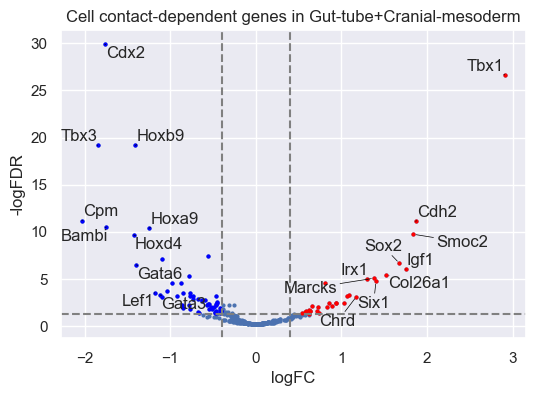

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


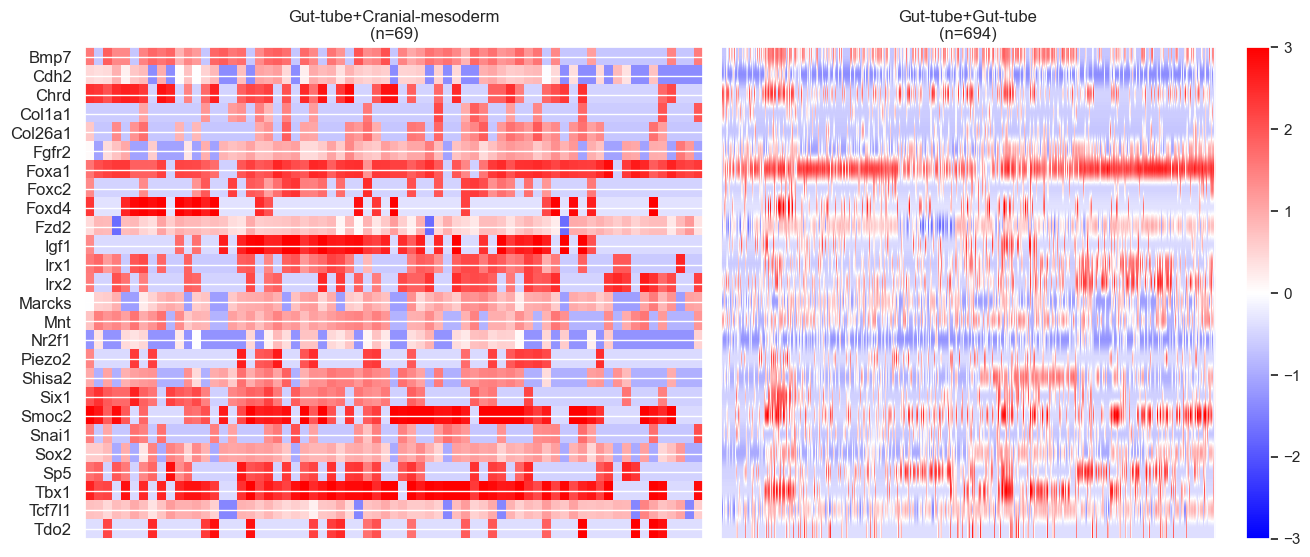

neighbor-dependent gene expression analysis:   4%|▍         | 1/24 [00:04<01:46,  4.64s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


1


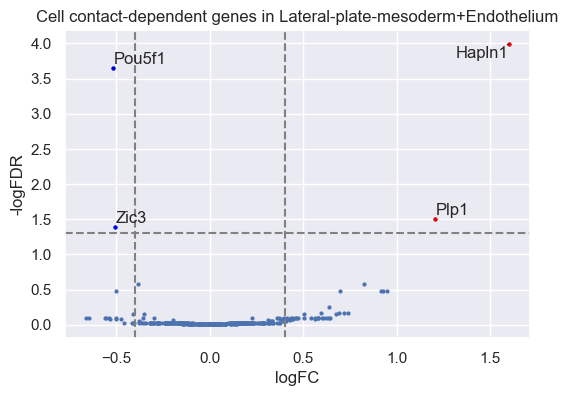

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


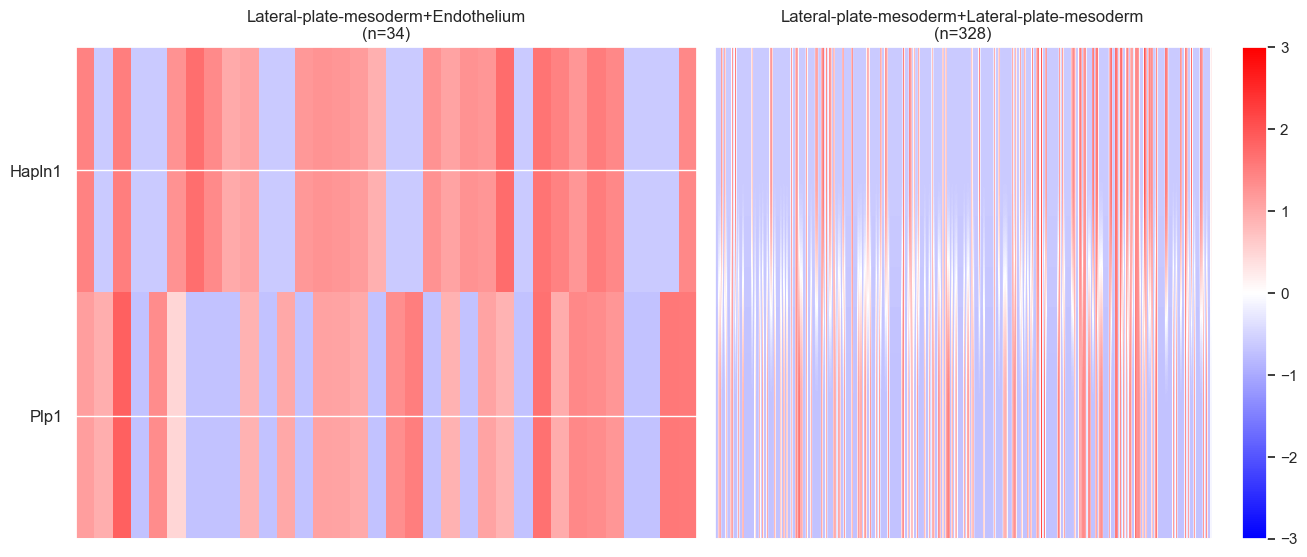

neighbor-dependent gene expression analysis:   8%|▊         | 2/24 [00:06<01:04,  2.91s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


2


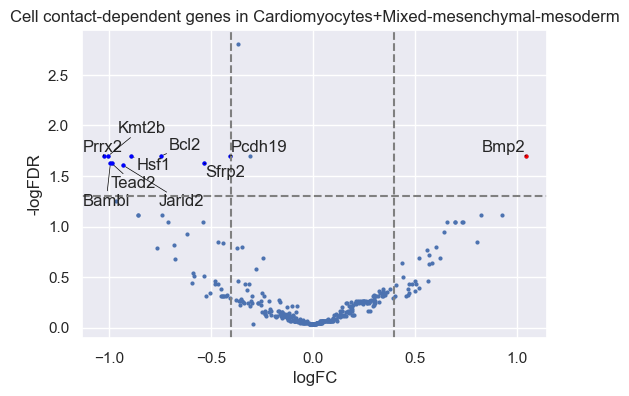

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


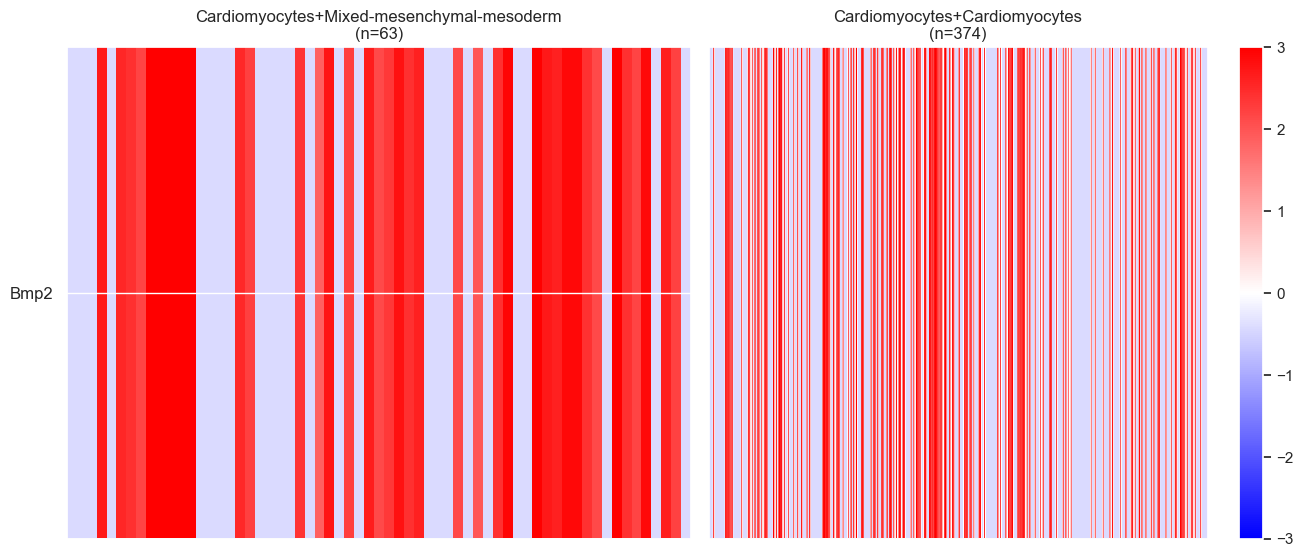

neighbor-dependent gene expression analysis:  12%|█▎        | 3/24 [00:10<01:09,  3.32s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


3
4


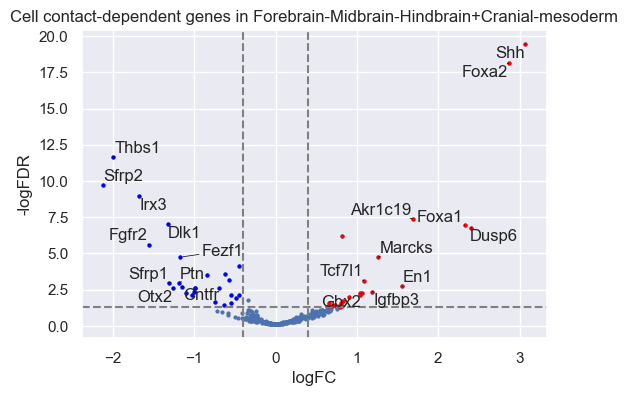

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


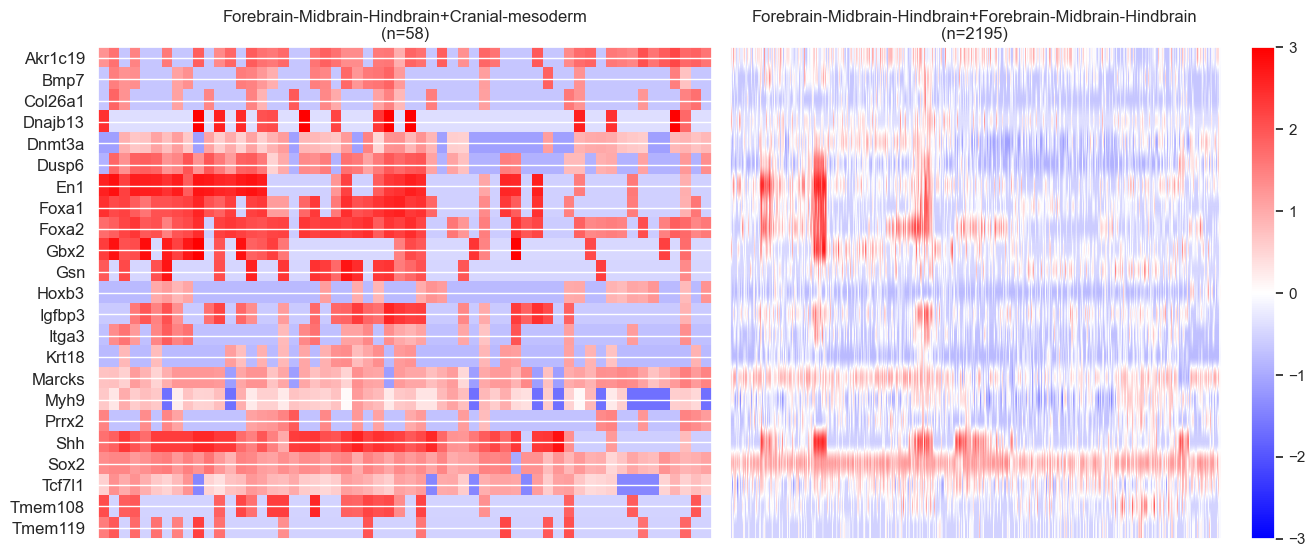

neighbor-dependent gene expression analysis:  21%|██        | 5/24 [00:13<00:43,  2.30s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


5


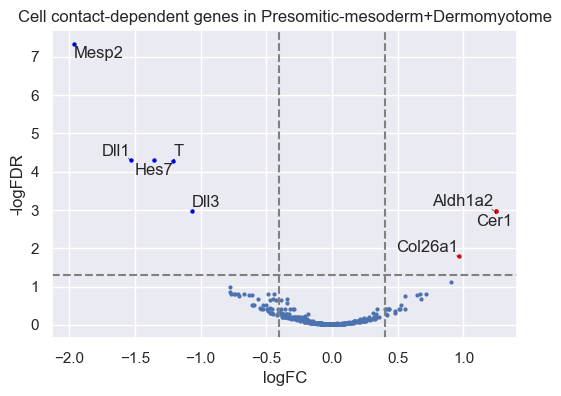

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


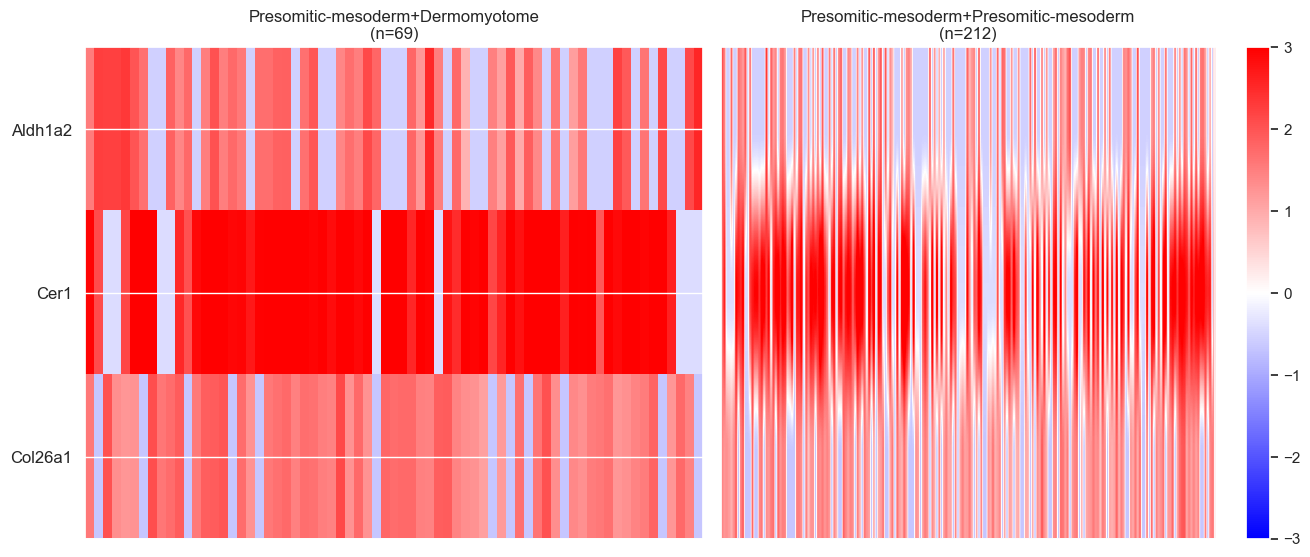

neighbor-dependent gene expression analysis:  25%|██▌       | 6/24 [00:15<00:39,  2.17s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


6


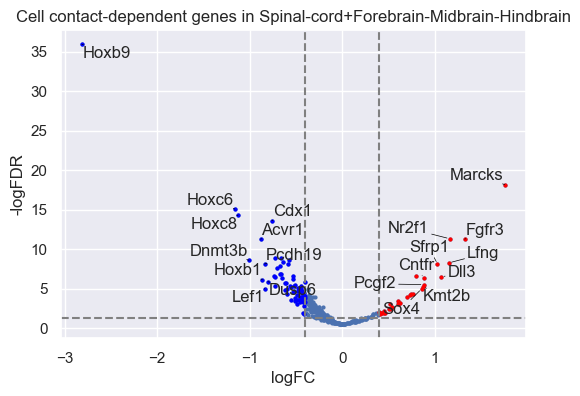

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


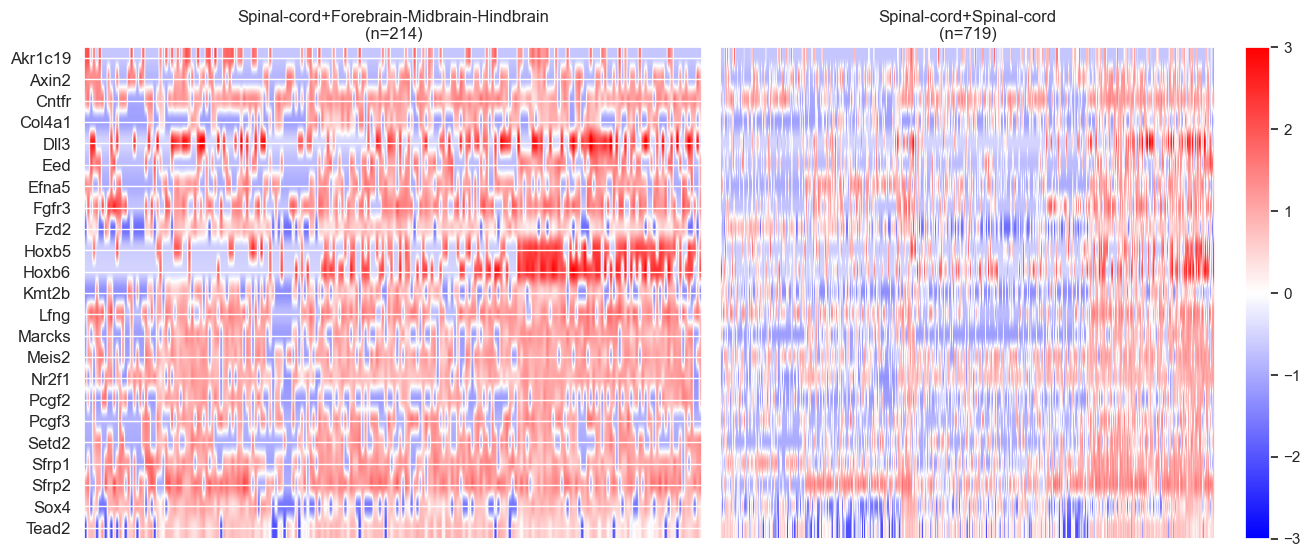

neighbor-dependent gene expression analysis:  29%|██▉       | 7/24 [00:18<00:41,  2.44s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


7


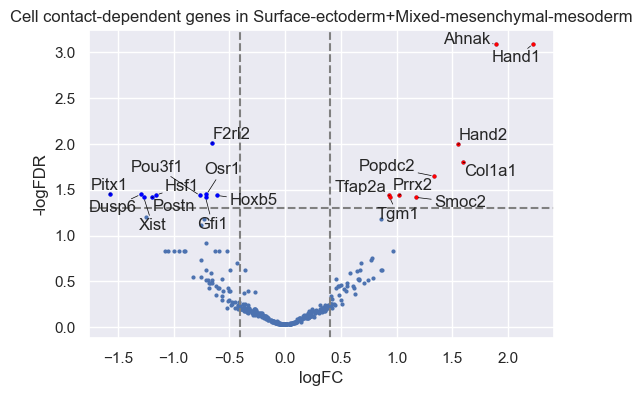

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


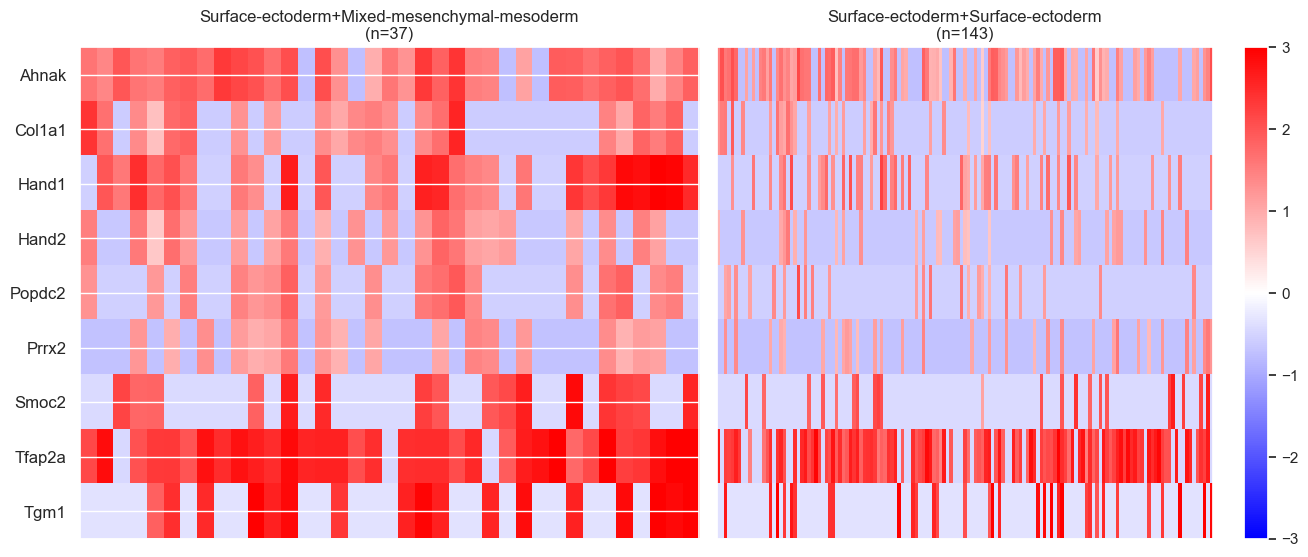

neighbor-dependent gene expression analysis:  33%|███▎      | 8/24 [00:21<00:42,  2.63s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


8


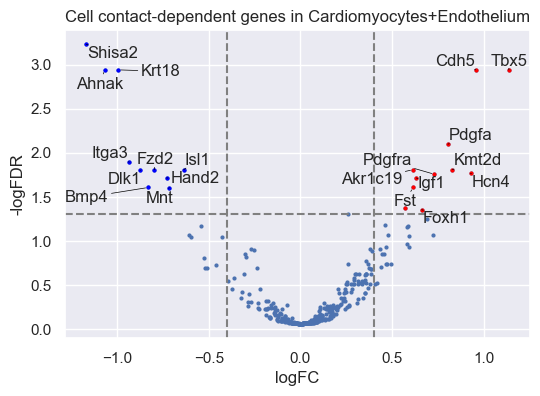

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


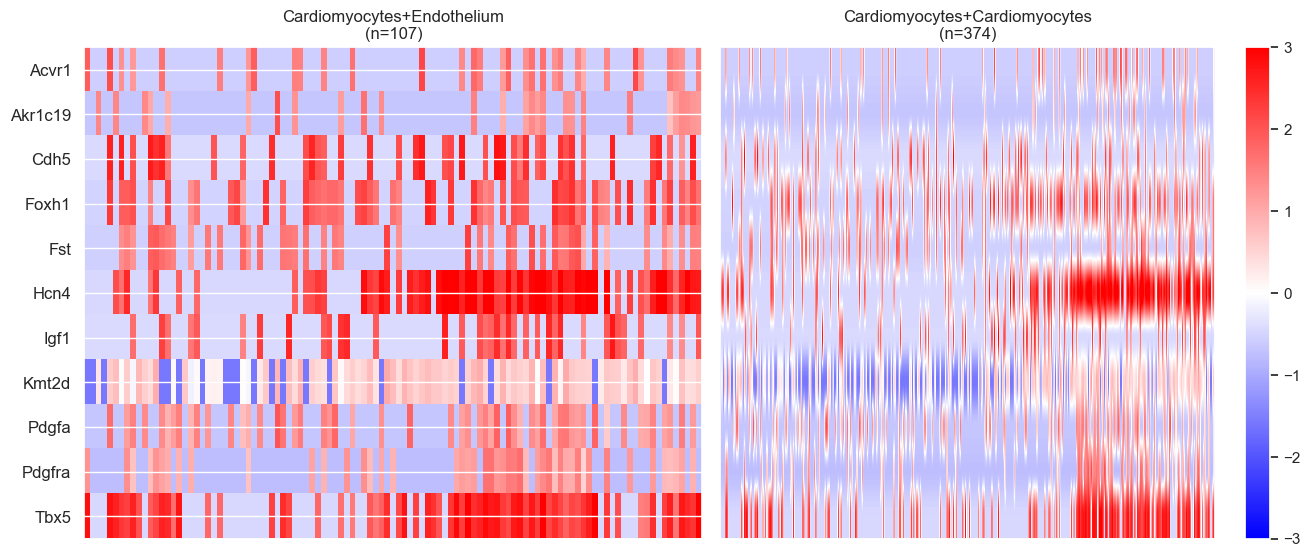

neighbor-dependent gene expression analysis:  38%|███▊      | 9/24 [00:26<00:50,  3.35s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


9


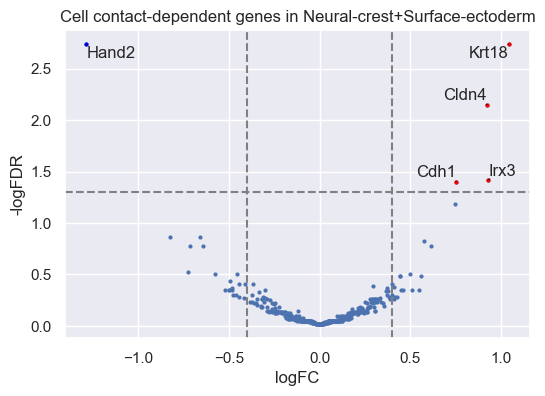

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


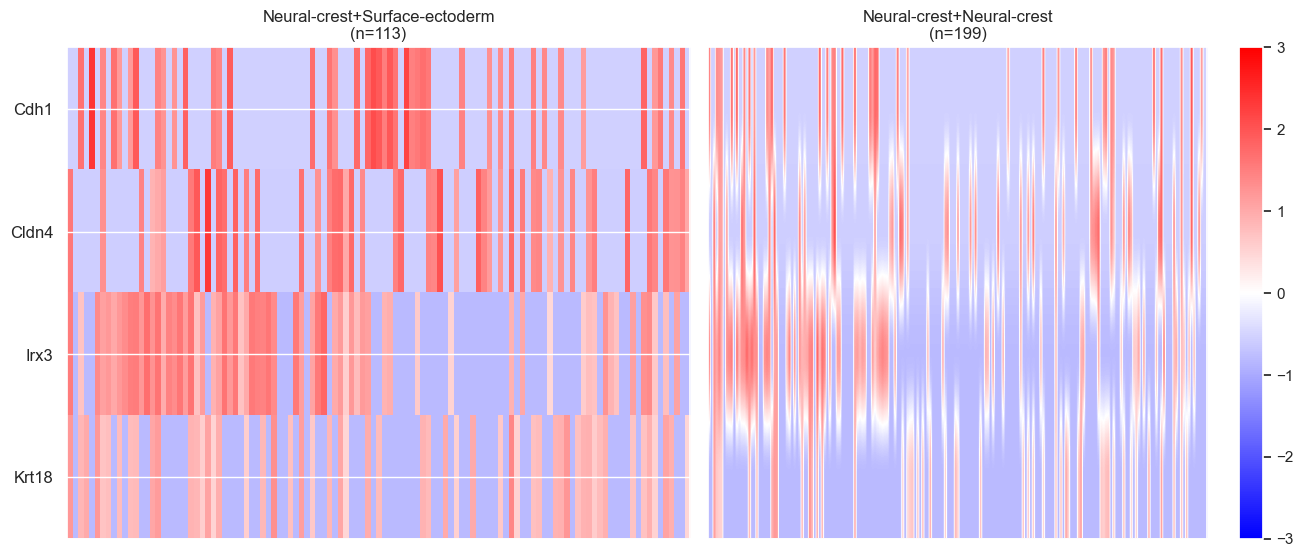

neighbor-dependent gene expression analysis:  42%|████▏     | 10/24 [00:28<00:40,  2.88s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


10


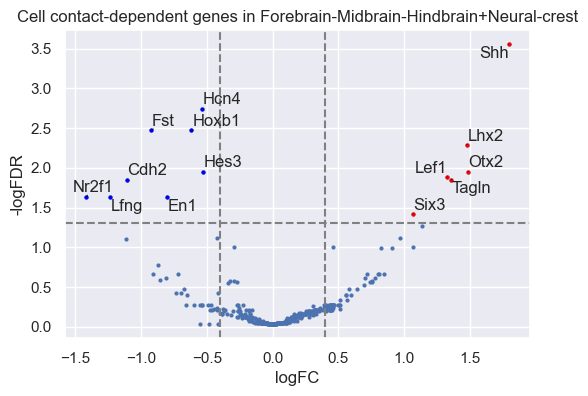

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


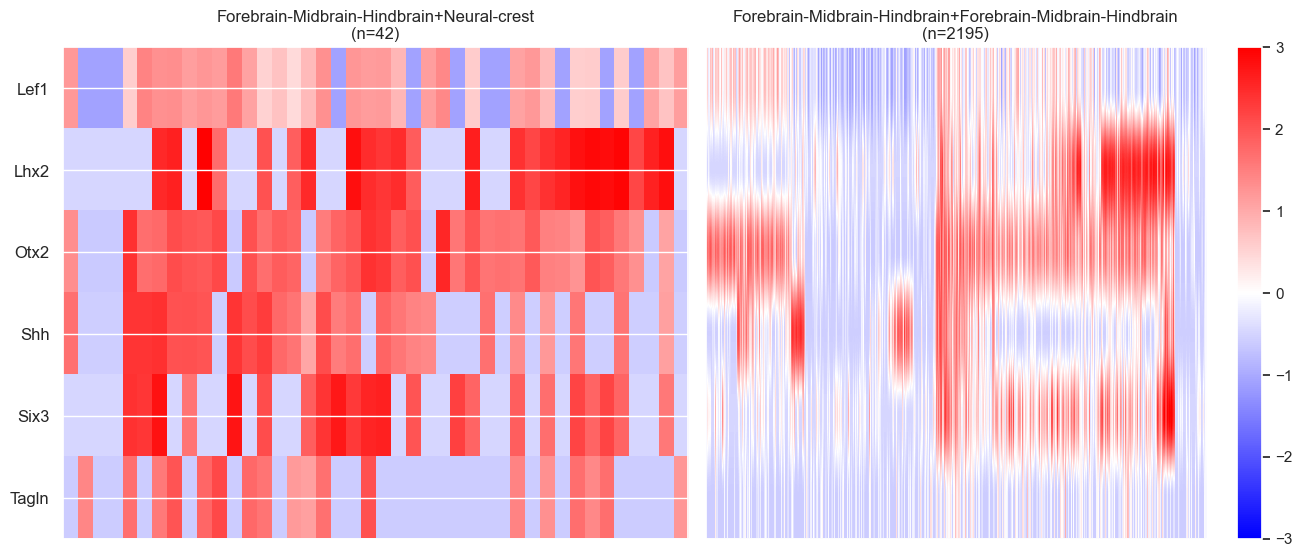

neighbor-dependent gene expression analysis:  46%|████▌     | 11/24 [00:30<00:34,  2.69s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


11


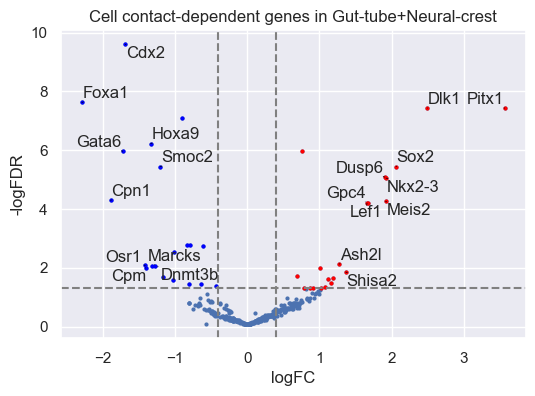

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


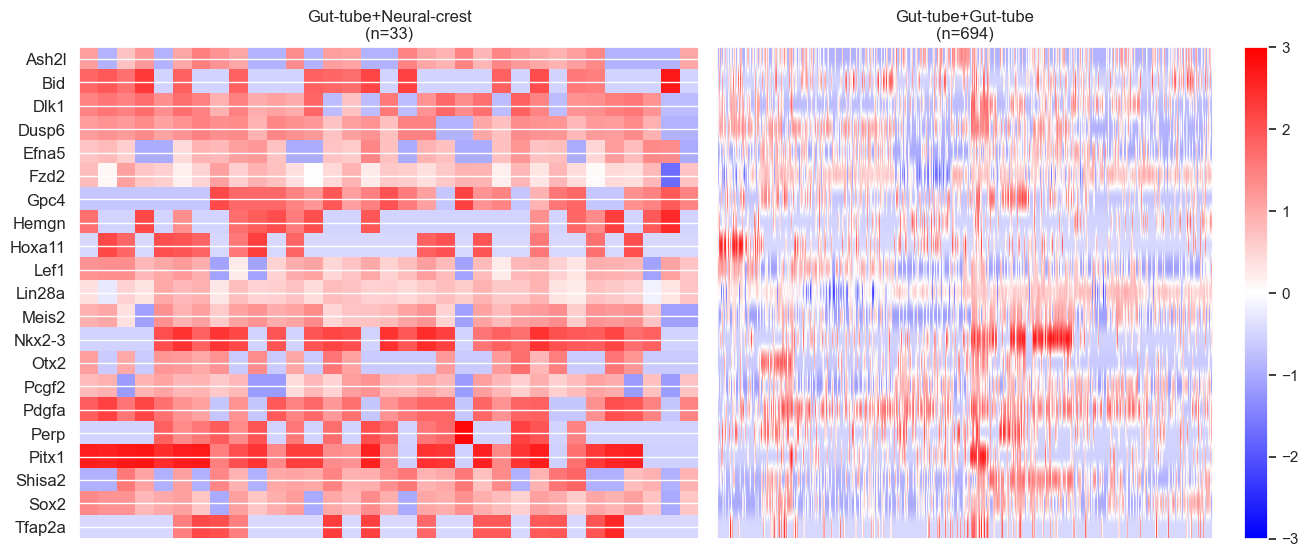

neighbor-dependent gene expression analysis:  50%|█████     | 12/24 [00:32<00:31,  2.66s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


12


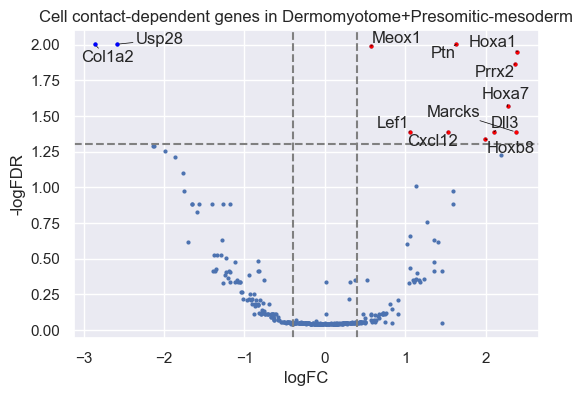

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


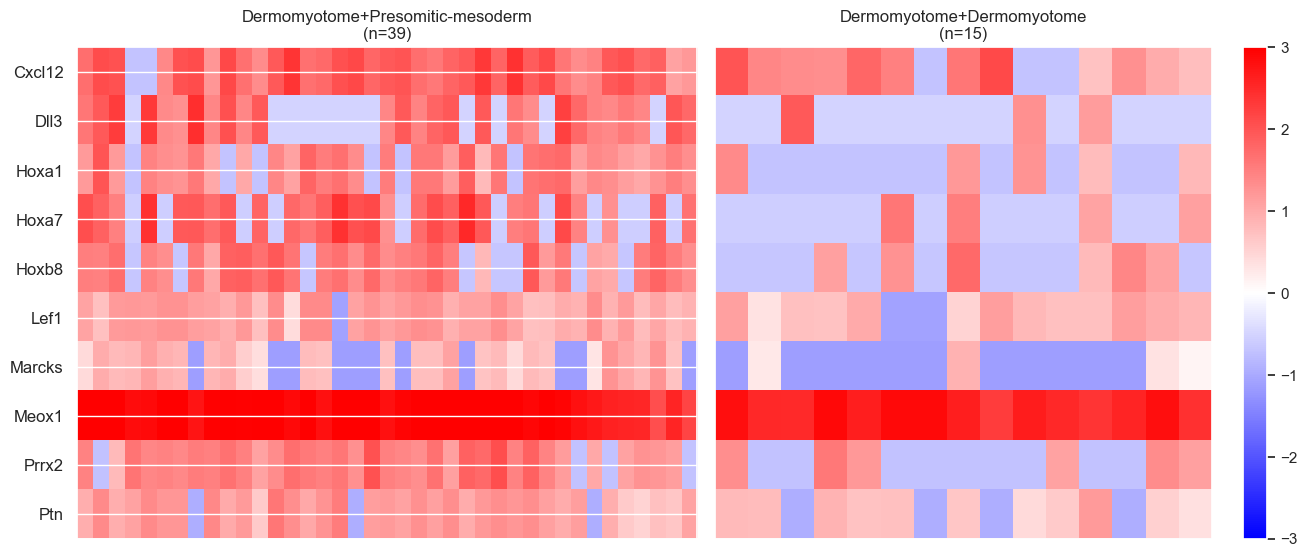

neighbor-dependent gene expression analysis:  54%|█████▍    | 13/24 [00:34<00:26,  2.44s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


13


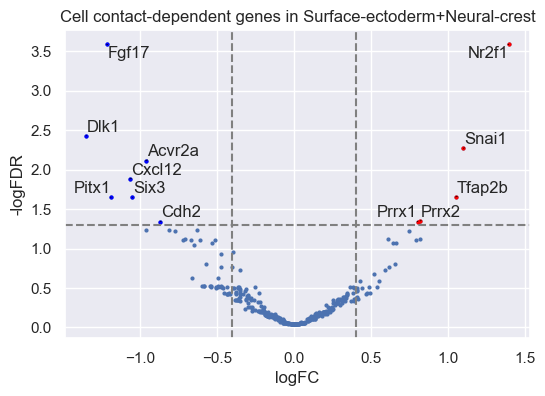

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


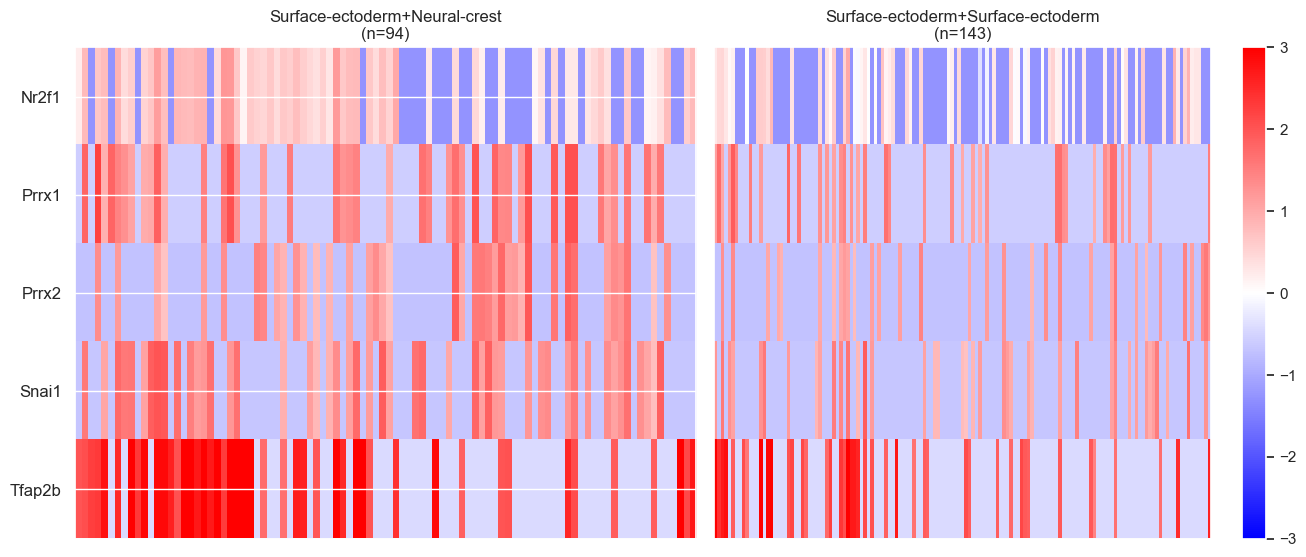

neighbor-dependent gene expression analysis:  58%|█████▊    | 14/24 [00:36<00:22,  2.28s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


14


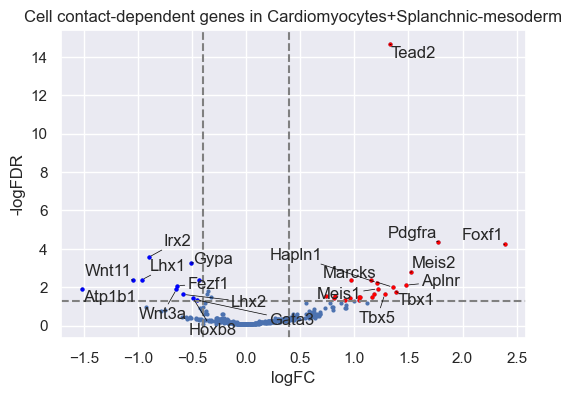

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


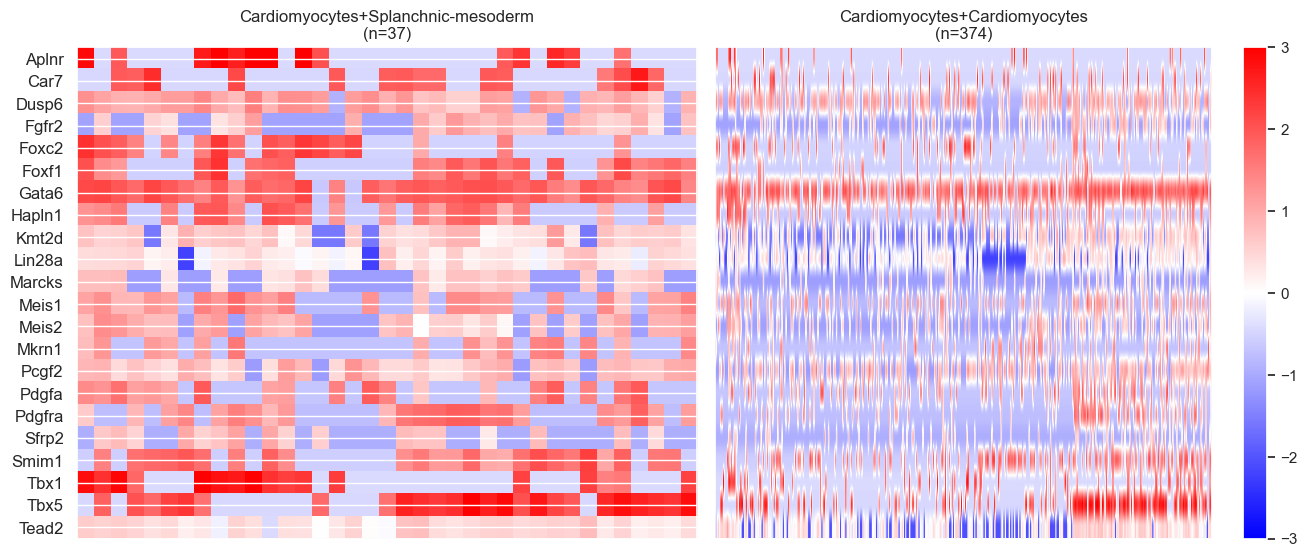

neighbor-dependent gene expression analysis:  62%|██████▎   | 15/24 [00:41<00:27,  3.03s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


15


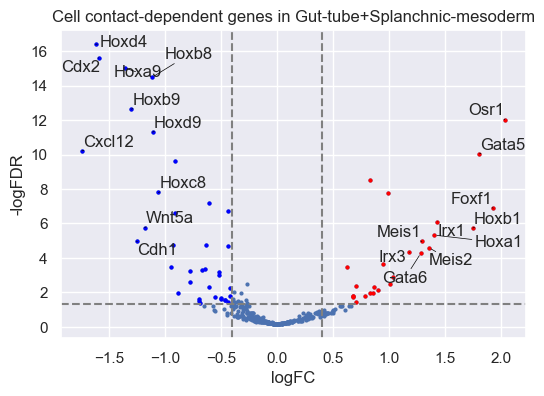

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


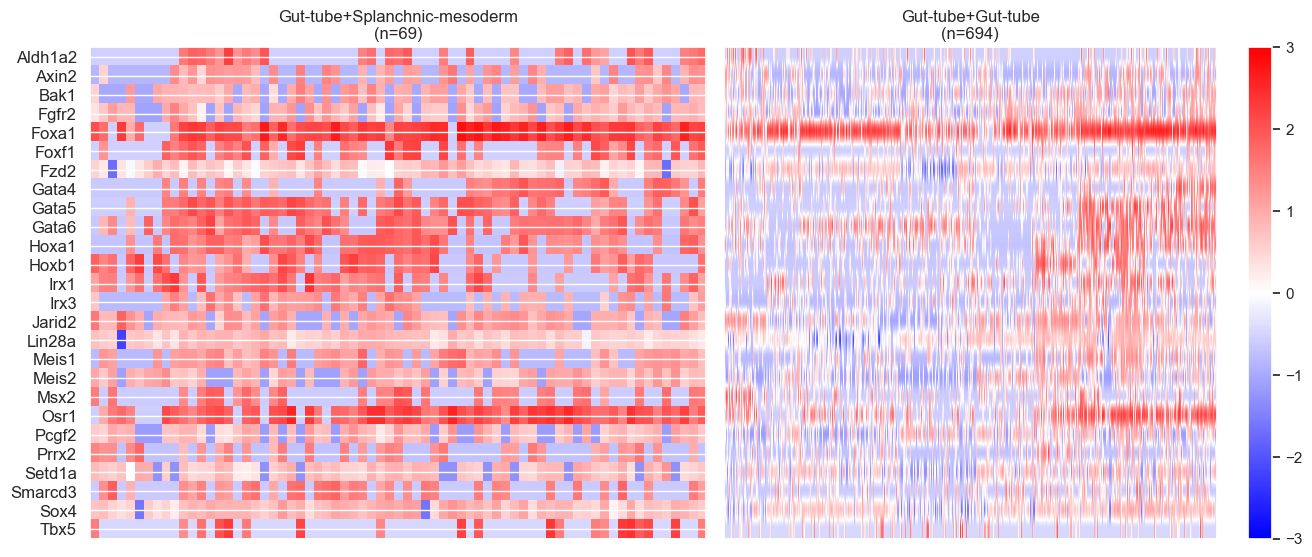

neighbor-dependent gene expression analysis:  67%|██████▋   | 16/24 [00:45<00:27,  3.46s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


16


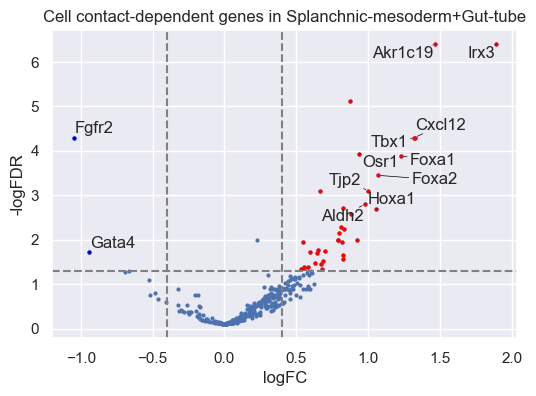

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


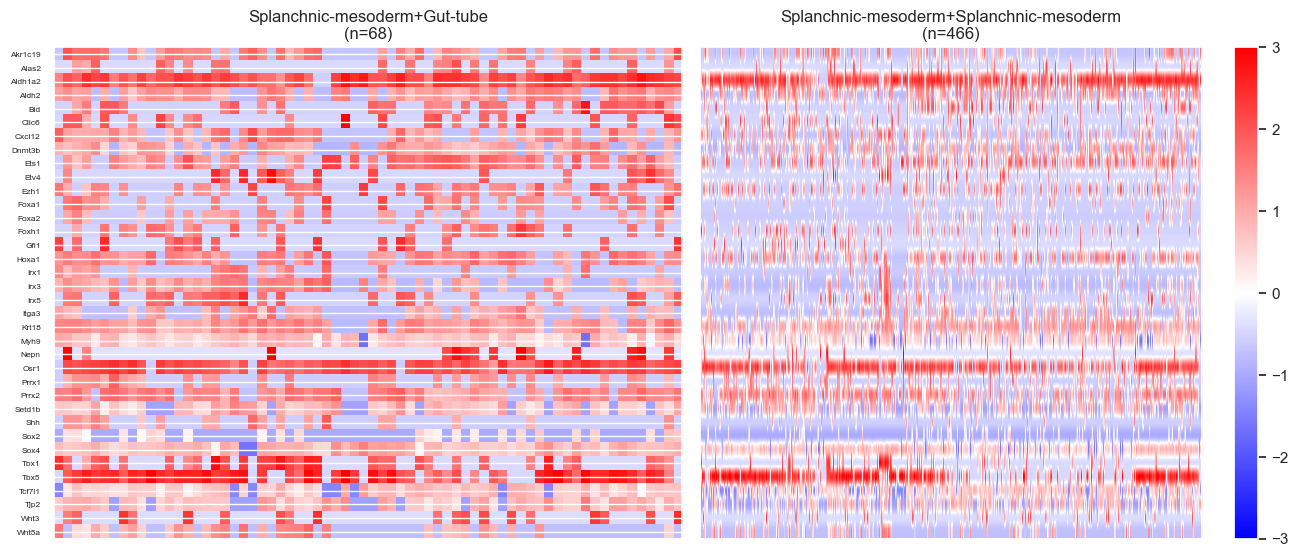

neighbor-dependent gene expression analysis:  71%|███████   | 17/24 [00:48<00:22,  3.18s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


17


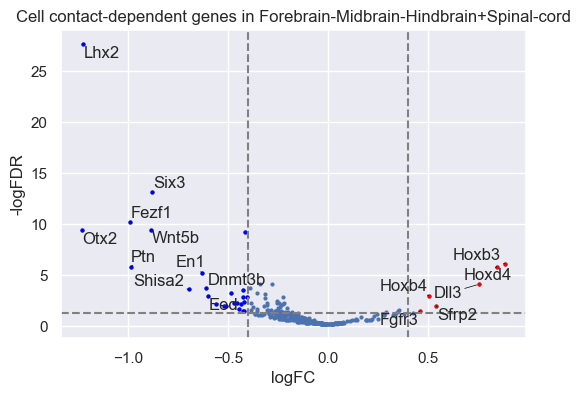

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


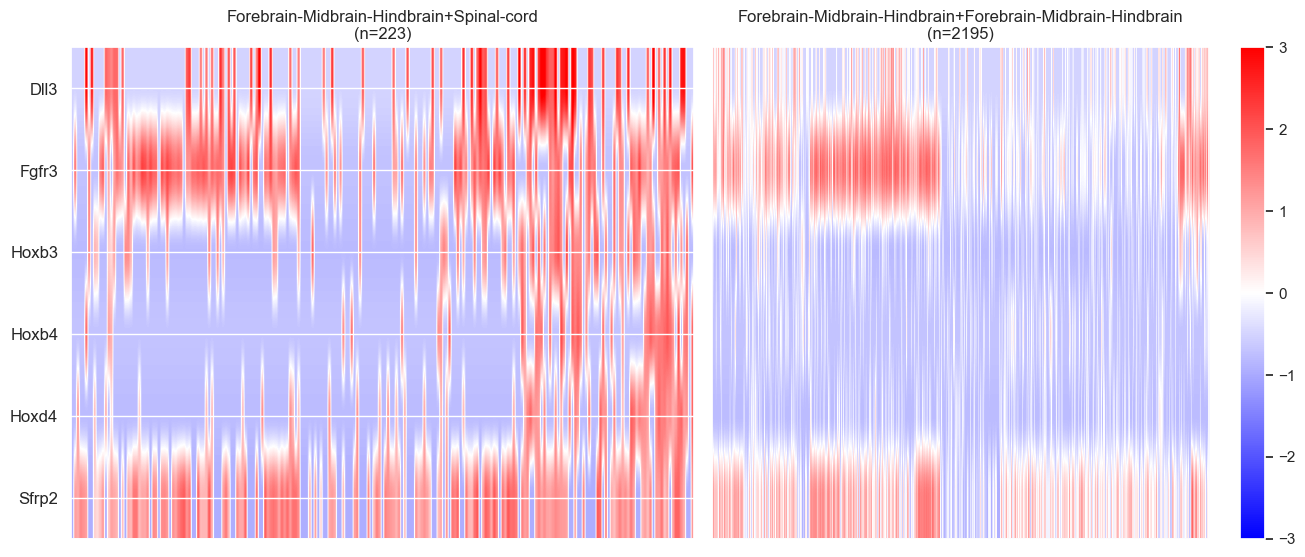

neighbor-dependent gene expression analysis:  75%|███████▌  | 18/24 [00:51<00:19,  3.20s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


18


neighbor-dependent gene expression analysis:  79%|███████▉  | 19/24 [00:52<00:11,  2.38s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


19


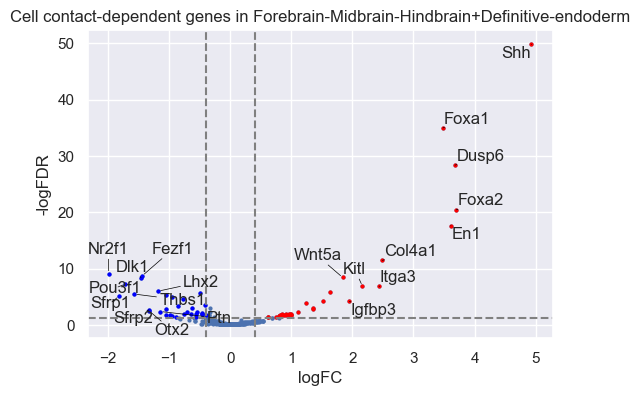

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


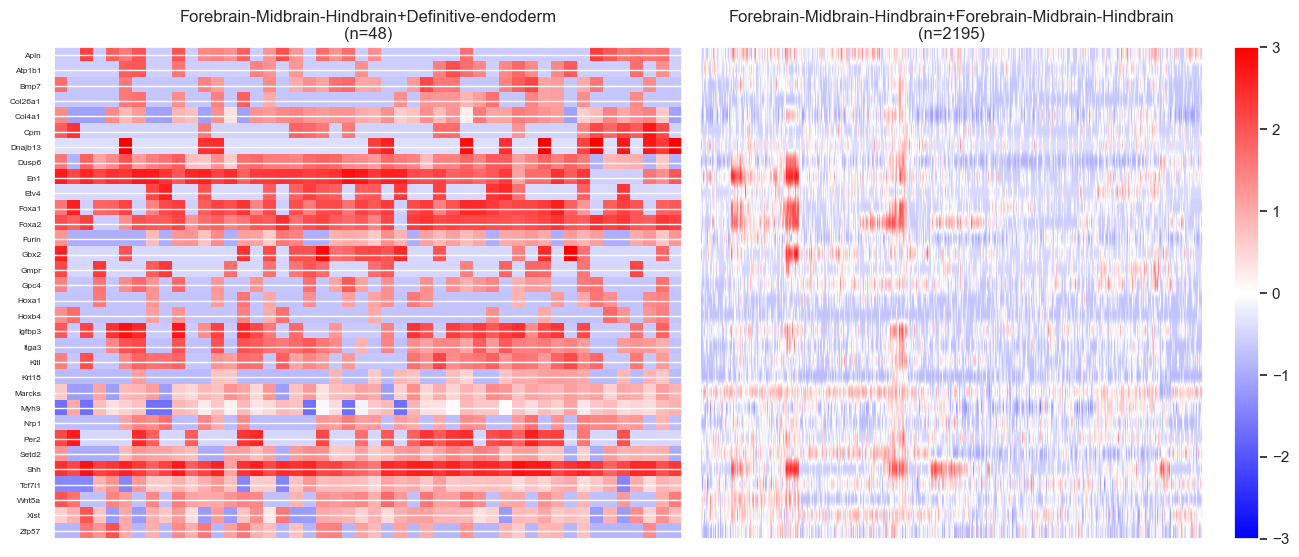

neighbor-dependent gene expression analysis:  83%|████████▎ | 20/24 [00:57<00:12,  3.18s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


20


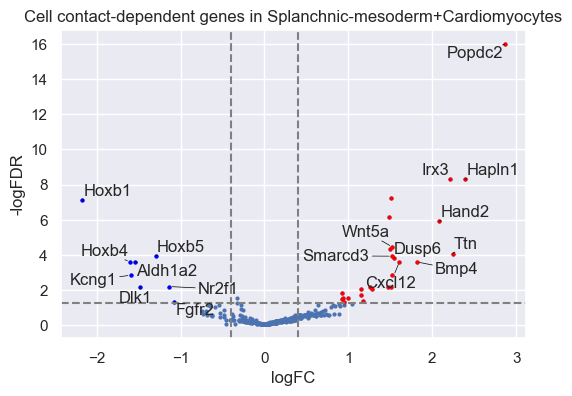

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


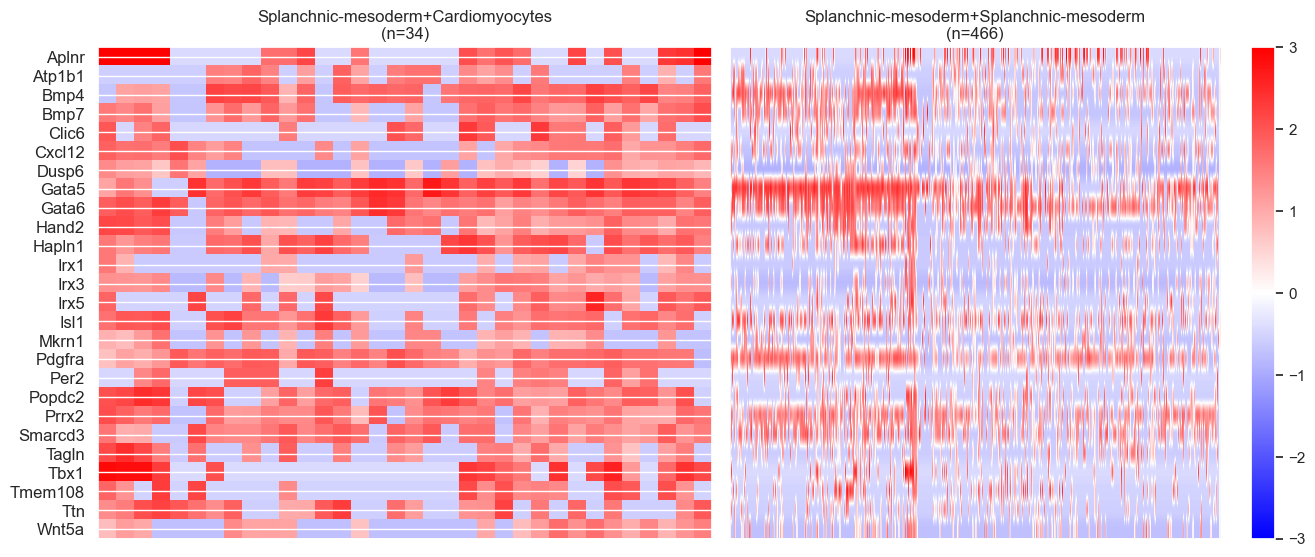

neighbor-dependent gene expression analysis:  88%|████████▊ | 21/24 [00:59<00:09,  3.03s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


21


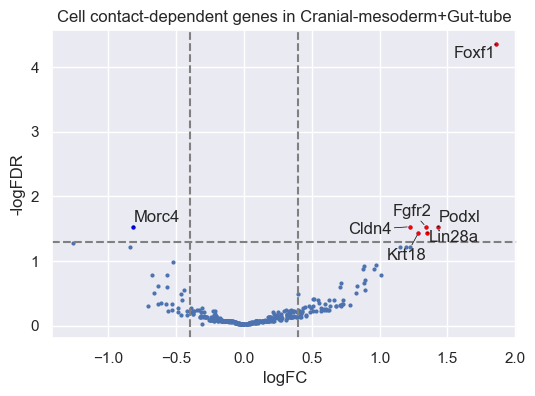

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


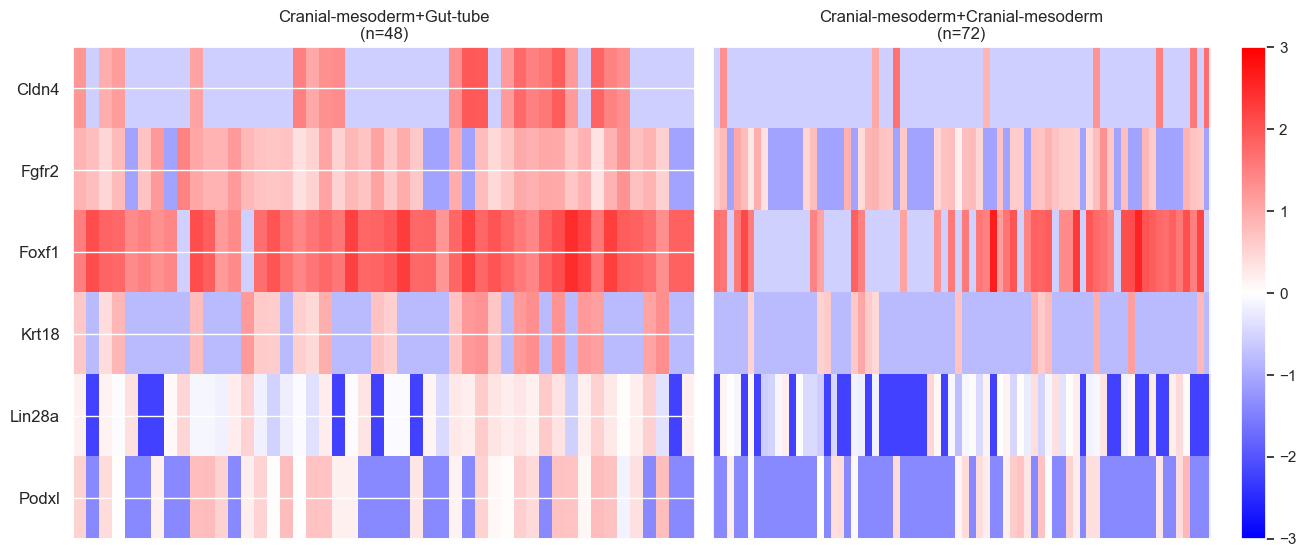

neighbor-dependent gene expression analysis:  92%|█████████▏| 22/24 [01:01<00:05,  2.66s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


22


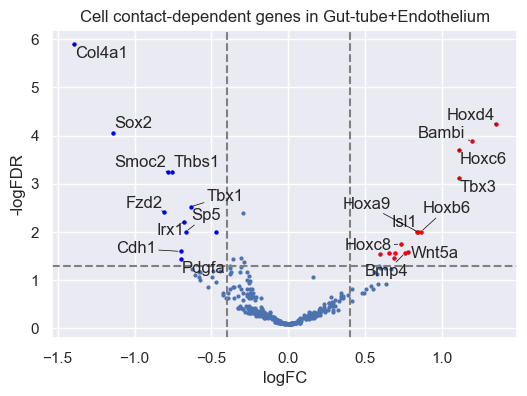

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


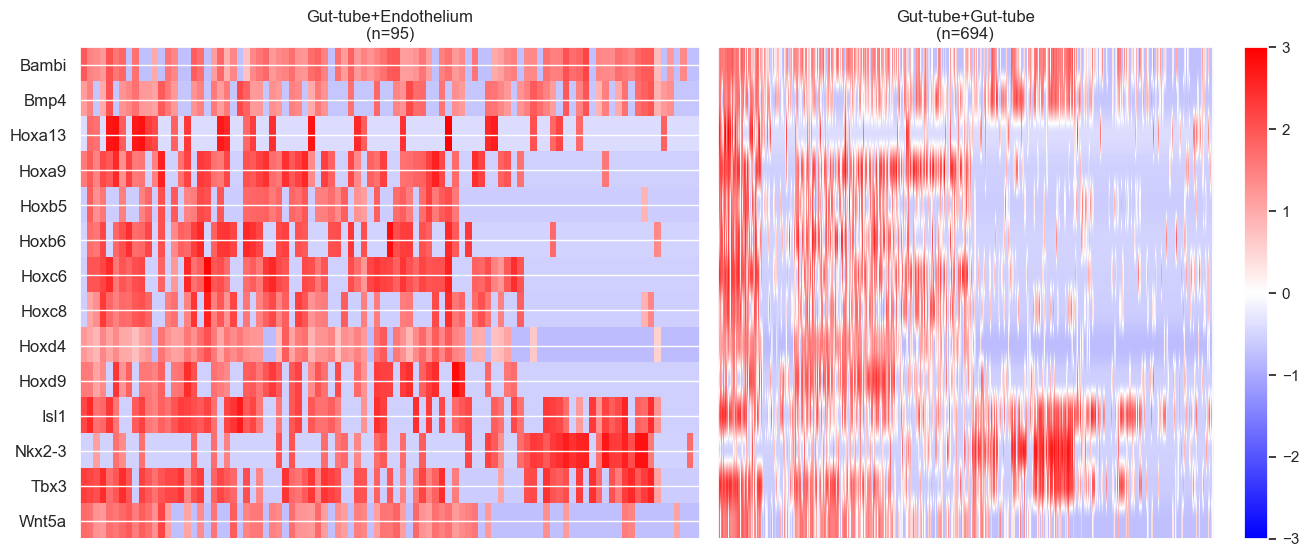

neighbor-dependent gene expression analysis:  96%|█████████▌| 23/24 [01:04<00:02,  2.70s/it]/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


23


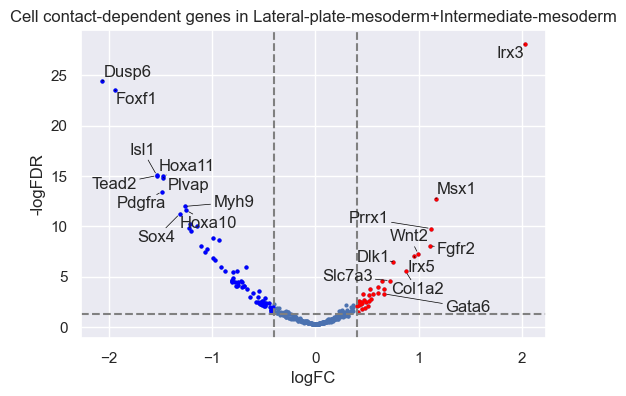

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


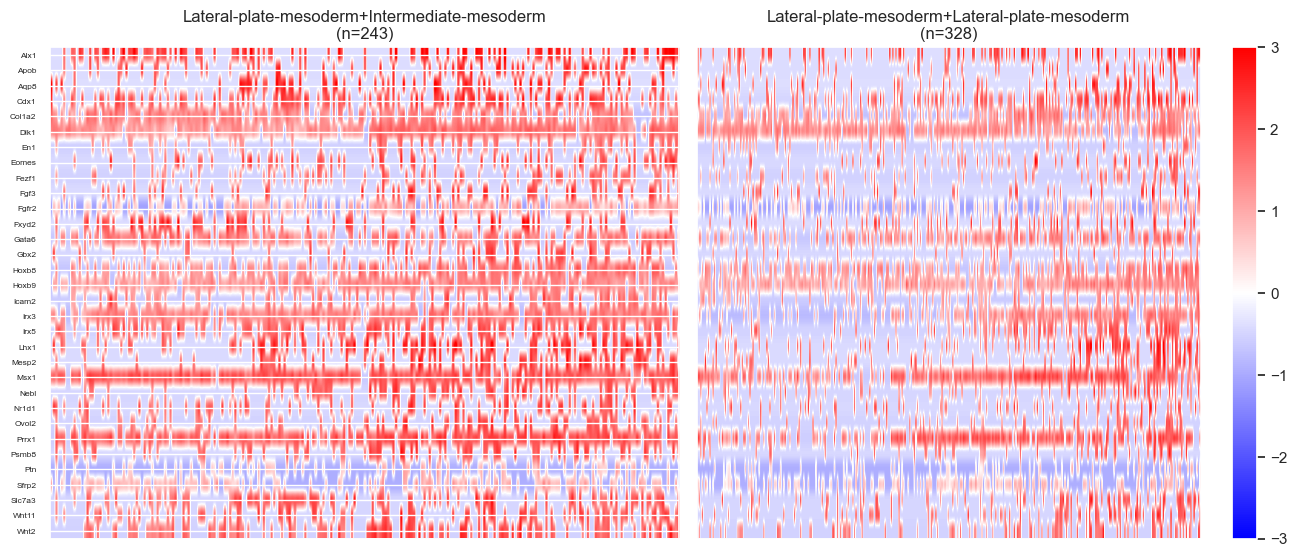

neighbor-dependent gene expression analysis: 100%|██████████| 24/24 [01:07<00:00,  2.82s/it]


In [17]:
# If save=True, all result files (DEG list: csv, heatmaps and volcano plots: pdf, gene expression values: txt) are saved in the "DE_results" folder in the root directory.
DEG_list = CellNeighborEX.DEanalysis.analyze_data(df_cell_id, df_gene_name, df_log_data, path_categorization, data_type, lrCutoff, pCutoff, pCutoff2, direction, normality_test, top_genes, save=True)


## Visualize neighbor-dependent gene expression in the spatial context

In [18]:
# Select a cell type and a DEG for spatial visualization and then load the data.
# For example, Pitx1 is up-regulated when Gut-tube are adjacent to Neural-crest.
path_selected = '/Users/kimh15/Downloads/DE_results/Gut-tube+Neural-crest/'
column_names = ['barcode', 'logdata', 'zscore']
heterotypic = pd.read_csv(path_selected + "Gut-tube+Neural-crest_Pitx1.txt", delimiter=",", names = column_names)
homotypic1 = pd.read_csv(path_selected + "Gut-tube+Gut-tube_Pitx1.txt", delimiter=",", names = column_names)
homotypic2 = pd.read_csv(path_selected + "Neural-crest+Neural-crest_Pitx1.txt", delimiter=",", names = column_names)
heterotypic['type'] = 'Gut-tube+Neural-crest'
homotypic1['type'] = 'Gut-tube+Gut-tube'
homotypic2['type'] = 'Neural-crest'
df_exp = pd.concat([heterotypic, homotypic1, homotypic2])

In [ ]:
# Set parameter values.
df_bg, df_red, df_blue, df_black = CellNeighborEX.visualization.set_parameters(df_processed, df_exp, beadsize_bg=5, edgecolor_bg=(0.85,0.85,0.85), beadcolor_bg=(0.85,0.85,0.85), beadsize_red=60, beadsize_blue=30, beadsize_black=30, type_red='Gut-tube+Neural-crest', type_blue='Gut-tube+Gut-tube', type_black='Neural-crest') 

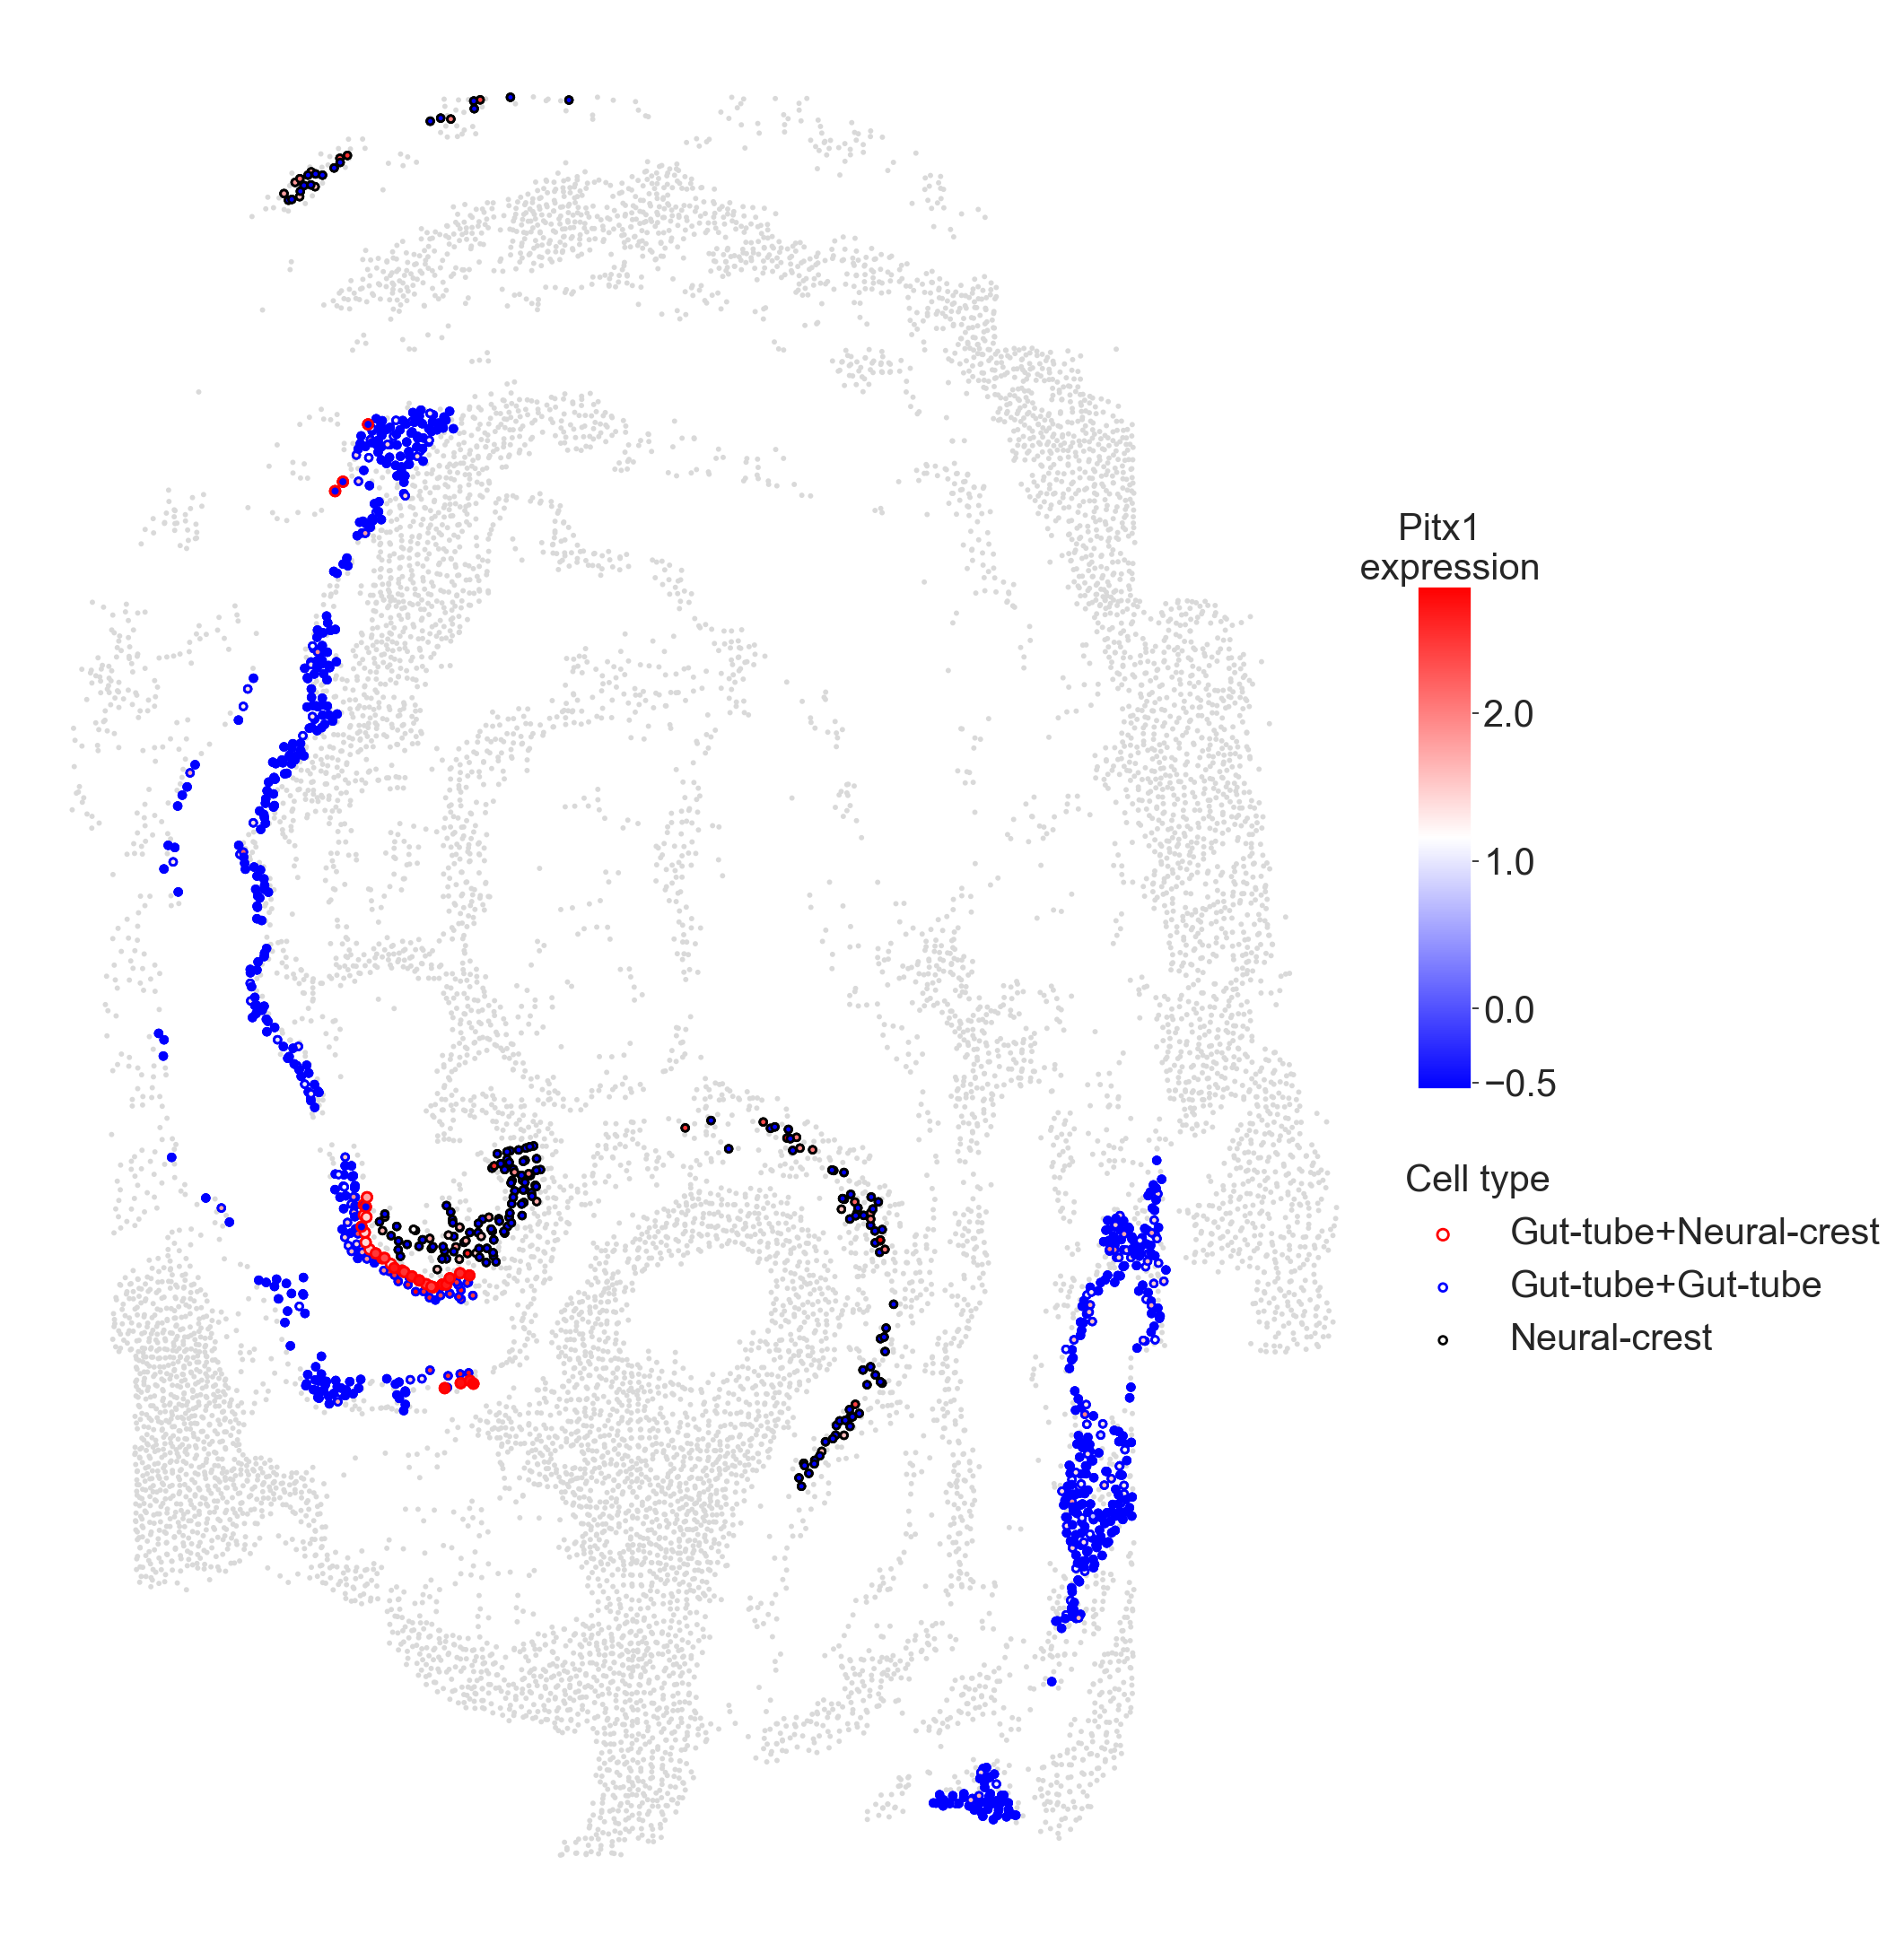

In [20]:
# Get the spatial map.
# zorder_red, zorder_blue, and zorder_black are parameters that determine the drawing order in the spatial map.
# If save=True, the spatial map (Pitx1.pdf) is saved in the "spatialMap" folder in the root directory.
CellNeighborEX.visualization.get_spatialPlot(df_bg, df_red, df_blue, df_black, label_red='Gut-tube+Neural-crest', label_blue='Gut-tube+Gut-tube', label_black='Neural-crest', label_gene='Pitx1', zorder_red=3.0, zorder_blue=2.0, zorder_black=4.0, figsize=(20,28), save=True)

FYI, the output files generated by CellNeighborEX in this tutorial can be downloaded at https://figshare.com/ndownloader/files/42352758.